In [1]:
# In this project, we segment Transmission Electron Microscopy images of the
# Drosophila first instar larva ventral nerve cord. We follow the approach presented in the U-net paper by 
# Olaf Ronneberger, Philipp Fischer, and Thomas Brox (https://arxiv.org/pdf/1505.04597.pdf).

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from sklearn.model_selection import train_test_split 
from sklearn.metrics import f1_score
import math
import cv2 as cv
import copy
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras import layers
from keras import callbacks
from keras import backend as K
from keras.utils import Sequence
from keras import optimizers
import pylab
from sklearn.metrics import accuracy_score
import h5py
import skimage
from skimage import transform
from keras.utils import CustomObjectScope
from keras.models import load_model
import imageio
from scipy import ndimage
from scipy.ndimage.interpolation import map_coordinates
from skimage.measure import label

/home/paperspace/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# We first load the labeled images and corresponding masks. There are only 30 labeled images.

In [4]:
imgs = np.array(imageio.imread('./train/train-volume.tif'))
masks = np.array(imageio.imread('./train/train-labels.tif'))/255
imgs = np.expand_dims(imgs,axis=-1)
masks = np.expand_dims(masks,axis=-1)

In [5]:
# We split the labeled images into a training set with 27 images and a validation set with 3 images.

In [6]:
trn_imgs,val_imgs,trn_masks,val_masks = train_test_split(imgs,masks,test_size=0.1)

In [7]:
# We now center and normalize all images.

In [8]:
mean_all = np.mean(trn_imgs)
std_all= np.std(trn_imgs)
trn_imgs = (trn_imgs - mean_all)/std_all
val_imgs = (val_imgs - mean_all)/std_all

In [9]:
num_trn,IMG_H,IMG_W,NUM_C = trn_imgs.shape
num_val = len(val_imgs)
num_trn, num_val

(27, 3)

In [10]:
# The size of the images. There is only one channel, since the images are greyscale. 

In [11]:
IMG_H,IMG_W,NUM_C

(512, 512, 1)

In [12]:
# The w_wmap_mask function computes the weight of each pixel in the loss function from the mask for each image.
# The closer a pixel is to the boundary, the higher its weight in the loss function.

In [13]:
def masks_from_mask(mask):
    mask = np.squeeze(mask)
    mask_lab = label(mask,connectivity=1)
    num_masks = np.amax(mask_lab)
    masks = np.empty((num_masks,IMG_H,IMG_W))
    for i in range(1,num_masks+1):
        masks[i-1]=mask_lab==i      
    
    return masks

In [14]:
def w_map_masks(masks):
    
    wo=2
    var=25
    disttonuclei = np.array([ndimage.distance_transform_edt(m==0) for m in masks])
    sort_dist_nuc = np.sort(disttonuclei, axis=0)
    short_dist_nuc = sort_dist_nuc[0]
    dist_back_arr =np.array([ndimage.distance_transform_edt(m) for m in masks])
    dist_back =  np.sort(dist_back_arr,axis=0)[-1]
    d1 = np.add(short_dist_nuc, dist_back)
    weights =  wo * np.exp(- np.power(d1,2)/(2 * var))
    
    return weights

In [15]:
def w_map_mask(mask):
    masks = masks_from_mask(mask)
    weights = w_map_masks(masks)
    weights = np.expand_dims(weights,axis=-1)
    weights = 1 + weights 
    return weights

In [16]:
# We apply the w_map_mask function to the training and validation sets to compute the appropriate weights for each.

In [17]:
trn_wmaps = np.array(list(map(w_map_mask,trn_masks)))
val_wmaps = np.array(list(map(w_map_mask,val_masks)))

In [18]:
# The deform_elastic function performs an elastic deformation on the image from a coarse 3x3 grid of 
# random displacement vectors in the x-y plane.

In [19]:
def deform_elastic(dx_coarse,dy_coarse,im):
    shape = (IMG_H,IMG_W)
    x, y = np.meshgrid(np.arange(IMG_H), np.arange(IMG_W), indexing='ij')
    dx = transform.resize(dx_coarse,(IMG_H,IMG_W),order=3)
    dy = transform.resize(dy_coarse,(IMG_H,IMG_W),order=3)
    indices = [np.reshape(x + dx, (-1)), np.reshape(y + dy, (-1))]
    result = np.empty_like(im)
    mode = 'reflect'
    spline_order = 1
    for i in range(im.shape[2]):
        result[:, :, i] = map_coordinates(
            im[:, :, i], indices, order=spline_order, mode=mode).reshape(shape)
    return result

In [20]:
# The round_mask function is used to restore a mask to all 0s and 1s after a transformation.

In [21]:
def round_mask(mask,thresh):
    mask = mask > thresh
    mask = mask.astype(float)
    return mask

In [22]:
def make_plot(img):
    return np.squeeze(img*std_all+mean_all)

In [23]:
# The num_fac_i define how many of each type of transformation will be used to augment the training set.
# num_fac_1 = 1 corresponds to the original training set.
# num_fac_2 should be set to 3 in flips are to be included, otherwise it should be set to 0.
# num_fac_3 should be set to 3 in 90 degree rotations are to be included, otherwise it should be set to 0.
# num_fac_4 indicates how many times each image should be shifted in the horizontal direction.
# num_fac_5 indicates how many times each image should be shifted in the vertical direction.
# num_fac_6 indicates how many times each image should be deformed elastically.

In [24]:
num_fac_1 = 1; tot_1 = num_fac_1
num_fac_2=0; tot_2 = tot_1 + num_fac_2;
num_fac_3 = 0; tot_3 = tot_2 + num_fac_3
num_fac_4 = 0; tot_4 = tot_3 + num_fac_4
num_fac_5 = 0; tot_5 = tot_4 + num_fac_5
num_fac_6 = 12; tot_6 = tot_5 + num_fac_6
tot_trn = num_trn * tot_6




In [25]:
# The train_ds class produces the original as well as augmented version of each image, mask, and weight map in the 
# training set. 

In [26]:
class train_ds():
    
    def __init__(self):
        
        return
    
    def __getitem__(self,indx):
        img = self.get_img(indx)
        mask = self.get_mask(indx)
        wmap = self.get_wmap(indx)
        return img,np.concatenate((mask,wmap),axis=-1)
    
    def get_wmap(self,indx):
        
        wmap = trn_wmaps[self.trn_im_indx]
        
        if self.train_indx<tot_1:
            return wmap
        
        if self.train_indx < tot_2 :
            if self.train_indx == tot_1:
                wmap = np.fliplr(wmap)
                return wmap
            elif self.train_indx == tot_1 + 1:
                wmap = np.flipud(wmap)
                return wmap
            else:
                wmap = np.fliplr(np.flipud(wmap))
                return wmap
        
        if self.train_indx < tot_3 :
            if self.train_indx == tot_2:
                wmap = ndimage.rotate(wmap, 90.0, mode='reflect',cval = 0.0,order=3,reshape=False)
                return wmap
            elif self.train_indx == tot_2 + 1:
                wmap = ndimage.rotate(wmap, 180.0, mode='reflect',cval = 0.0,order=3,reshape=False)
                return wmap
            else:
                wmap = ndimage.rotate(wmap, 270.0, mode='reflect',cval = 0.0,order=3,reshape=False)
                return wmap
            
        if self.train_indx < tot_4 :
            wmap = ndimage.shift(wmap,(0,self.shiftlrn * IMG_W,0),mode='reflect',cval=0.0,order=3)
            return wmap
            
        if self.train_indx < tot_5 :
            wmap = ndimage.shift(wmap,(self.shiftudn*IMG_H,0,0),mode='reflect',cval=0.0,order=3)
            return wmap
        
        wmap = deform_elastic(self.dx_coarse,self.dy_coarse,wmap)
        
        
        return wmap 
    
    def get_mask(self,indx):
        
        
        mask = trn_masks[self.trn_im_indx]
            
        if self.train_indx<tot_1:
            return mask
        
        if self.train_indx < tot_2 :
            if self.train_indx == tot_1:
                mask = np.fliplr(mask)
                return mask
            elif self.train_indx == tot_1 + 1:
                mask = np.flipud(mask)
                return mask
            else:
                mask = np.fliplr(np.flipud(mask))
                return mask
        
        if self.train_indx < tot_3 :
            if self.train_indx == tot_2:
                mask = ndimage.rotate(mask, 90.0, mode='reflect',cval = 0.0,order=3,reshape=False)
                return mask
            elif self.train_indx == tot_2 + 1:
                mask = ndimage.rotate(mask, 180.0, mode='reflect',cval = 0.0,order=3,reshape=False)
                return mask
            else:
                mask = ndimage.rotate(mask, 270.0, mode='reflect',cval = 0.0,order=3,reshape=False)
                return mask
            
        if self.train_indx < tot_4 :
            mask = ndimage.shift(mask,(0,self.shiftlrn * IMG_W,0),mode='reflect',cval=0.0,order=3)
            mask = round_mask(mask,0.5)
            return mask
            
        if self.train_indx < tot_5 :
            mask = ndimage.shift(mask,(self.shiftudn*IMG_H,0,0),mode='reflect',cval=0.0,order=3)
            mask = round_mask(mask,0.5)
            return mask
        
        mask = deform_elastic(self.dx_coarse,self.dy_coarse,mask)
        mask = round_mask(mask,0.5)
        
        return mask
    
    def get_img(self,indx):
          
        
        self.trn_im_indx = indx % num_trn
        
        img = trn_imgs[self.trn_im_indx]
        
        self.train_indx = indx//num_trn
        
        if self.train_indx <tot_1:
            return img
        
        
        if self.train_indx < tot_2:
            if self.train_indx == tot_1:
                img = np.fliplr(img)
                return img
            elif self.train_indx == tot_1 + 1:
                img = np.flipud(img)
                return img
            else:
                img = np.fliplr(np.flipud(img))
                return img
        
        if self.train_indx < tot_3:
            if self.train_indx == tot_2:
                img = ndimage.rotate(img, 90.0, mode='reflect',cval = 0.0,order=3,reshape=False)
                return img
            elif self.train_indx == tot_2 + 1:
                img = ndimage.rotate(img, 180.0, mode='reflect',cval = 0.0,order=3,reshape=False)
                return img
            else:
                img = ndimage.rotate(img, 270.0, mode='reflect',cval = 0.0,order=3,reshape=False)
                return img
            
        
        
        if self.train_indx < tot_4:
            np.random.seed(seed=self.train_indx)
            self.shiftlrn = .4 * np.random.rand() - .2
            img = ndimage.shift(img,(0,self.shiftlrn * IMG_W,0),mode='reflect',cval=0.0,order=3)
            return img
        
        
            
        if self.train_indx < tot_5:
            np.random.seed(seed = self.train_indx + tot_trn)
            self.shiftudn = .4 * np.random.rand() - .2
            img = ndimage.shift(img,(self.shiftudn*IMG_H,0,0),mode='reflect',cval=0.0,order=3)
            return img
                  
         
        np.random.seed(seed = self.train_indx + 2* tot_trn)
        
        self.dx_coarse = 5*np.random.normal(loc=0.0,scale=10,size=(3,3))

        np.random.seed(seed=self.train_indx + 3* tot_trn )

        self.dy_coarse = 5*np.random.normal(loc=0.0,scale=10,size=(3,3))
        img = deform_elastic(self.dx_coarse,self.dy_coarse,img)
        
        return img
        
    
    def __len__(self):
        return tot_trn
    

In [27]:
# The valid_ds class produces each image, mask, and weight map in the validation set. 

In [28]:
class valid_ds():
    
    def __init__(self):
        return
    
    def __getitem__(self,indx):
        img = self.get_img(indx)
        mask = self.get_mask(indx)
        wmap = self.get_wmap(indx)
        return img,np.concatenate((mask,wmap),axis=-1)
    
    def get_wmap(self,indx):
        wmap = val_wmaps[indx]
        return wmap
    
    def get_mask(self,indx):
        mask = val_masks[indx]
        return mask
    
    def get_img(self,indx):
        img = val_imgs[indx]
        return img
    
    def __len__(self):
        return num_val
    

In [29]:
# trn_ds and val_ds are instances of the train_ds and valid_ds classes, respectively.

In [30]:
trn_ds = train_ds() 
val_ds = valid_ds()

In [31]:
# We plot the first image, as well as the corresponding mask and weight map from the training set.

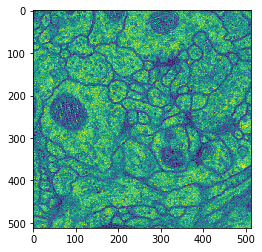

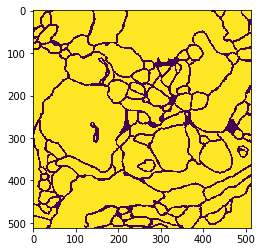

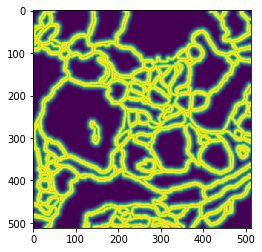

In [32]:
indx=0
img,mask_weight = trn_ds[indx]
mask = mask_weight[:,:,0]
weight = mask_weight[:,:,1]
plt.figure('img')
plt.imshow(make_plot(img))
plt.figure('mask')
plt.imshow(mask)
plt.figure('weight')
plt.imshow(weight)

In [33]:
# We plot the same image after applying an elastic deformation, as well as the corresponding mask and weight map.

/home/paperspace/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


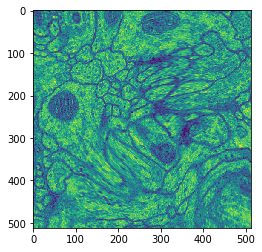

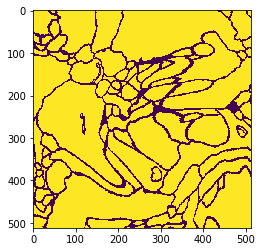

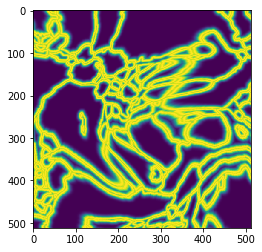

In [34]:
indx=num_trn
img,mask_weight = trn_ds[indx]
mask = mask_weight[:,:,0]
weight = mask_weight[:,:,1]
plt.figure('img')
plt.imshow(make_plot(img))
plt.figure('mask')
plt.imshow(mask)
plt.figure('weight')
plt.imshow(weight)

In [35]:
# We plot the same image again after applying another elastic deformation, 
# as well as the corresponding mask and weight map.

/home/paperspace/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


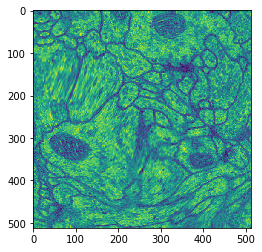

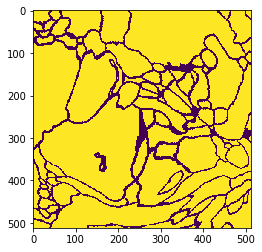

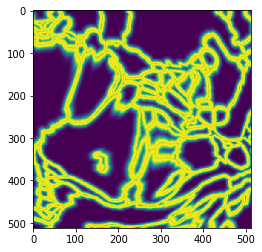

In [36]:
indx=2*num_trn
img,mask_weight = trn_ds[indx]
mask = mask_weight[:,:,0]
weight = mask_weight[:,:,1]
plt.figure('img')
plt.imshow(make_plot(img))
plt.figure('mask')
plt.imshow(mask)
plt.figure('weight')
plt.imshow(weight)

In [37]:
# The train_dl loads the training data into the model in batches. The order of the images is randomized at the end
# of every epoch.

In [38]:
class train_dl(Sequence):
    def __init__(self,bs=1):
        self.bs = bs
        self.num_batch = len(self)
        self.num_img = self.bs * self.num_batch
        self.indices = np.split(np.random.permutation(self.num_img),self.num_batch)
        
    
    def on_epoch_end(self):
        self.indices = np.split(np.random.permutation(self.num_img),self.num_batch)
        
        
        
    def __len__(self):
        return tot_trn // self.bs
    
    def __getitem__(self,indx):
        batch = [trn_ds[i] for i in self.indices[indx]]
        batch_img = np.array([data[0] for data in batch])
        batch_mask = np.array([data[1] for data in batch])
        return batch_img,batch_mask
    
  
        

In [39]:
# The valid_dl loads the validation data into the model in batches.

In [40]:
class valid_dl(Sequence):
    def __init__(self,bs=1):
        self.bs = bs
        self.num_batch = len(self)
        self.num_img = self.bs * self.num_batch
        self.indices = np.split(np.arange(0,self.num_img),self.num_batch)
        
    def __len__(self):
        return num_val // self.bs
    
    def __getitem__(self,indx):
        batch = [val_ds[i] for i in self.indices[indx]]
        batch_img = np.array([data[0] for data in batch])
        batch_mask = np.array([data[1] for data in batch])
        return batch_img,batch_mask

In [41]:
# The make_unet function creates the U-net model. We apply a dropout layer between the encoder and decoder.

In [42]:
def make_unet():
    
    
    data = layers.Input(shape=(IMG_H,IMG_W,NUM_C))


    conv1a = layers.Conv2D(64,3,strides=1,padding='same',data_format='channels_last',activation='relu',use_bias=True,
                               kernel_initializer = 'he_normal',bias_initializer='zeros')(data)
    conv1b = layers.Conv2D(64,3,strides=1,padding='same',data_format='channels_last',activation='relu',use_bias=True,
                               kernel_initializer = 'he_normal',bias_initializer='zeros')(conv1a)
    pool1 = layers.MaxPooling2D(pool_size=2,padding='same',data_format = 'channels_last')(conv1b)


    conv2a = layers.Conv2D(128,3,strides=1,padding='same',data_format='channels_last',activation='relu',use_bias=True,
                               kernel_initializer = 'he_normal',bias_initializer='zeros')(pool1)
    conv2b = layers.Conv2D(128,3,strides=1,padding='same',data_format='channels_last',activation='relu',use_bias=True,
                               kernel_initializer = 'he_normal',bias_initializer='zeros')(conv2a)
    pool2 = layers.MaxPooling2D(pool_size=2,padding='same',data_format = 'channels_last')(conv2b)


    conv3a = layers.Conv2D(256,3,strides=1,padding='same',data_format='channels_last',activation='relu',use_bias=True,
                               kernel_initializer = 'he_normal',bias_initializer='zeros')(pool2)
    conv3b = layers.Conv2D(256,3,strides=1,padding='same',data_format='channels_last',activation='relu',use_bias=True,
                               kernel_initializer = 'he_normal',bias_initializer='zeros')(conv3a)
    pool3 = layers.MaxPooling2D(pool_size=2,padding='same',data_format = 'channels_last')(conv3b)


    conv4a = layers.Conv2D(512,3,strides=1,padding='same',data_format='channels_last',activation='relu',use_bias=True,
                               kernel_initializer = 'he_normal',bias_initializer='zeros')(pool3)
    conv4b = layers.Conv2D(512,3,strides=1,padding='same',data_format='channels_last',activation='relu',use_bias=True,
                               kernel_initializer = 'he_normal',bias_initializer='zeros')(conv4a)
    pool4 = layers.MaxPooling2D(pool_size=2,padding='same',data_format = 'channels_last')(conv4b)


    conv5a = layers.Conv2D(1024,3,strides=1,padding='same',data_format='channels_last',activation='relu',use_bias=True,
                               kernel_initializer = 'he_normal',bias_initializer='zeros')(pool4)
    conv5b = layers.Conv2D(1024,3,strides=1,padding='same',data_format='channels_last',activation='relu',use_bias=True,
                               kernel_initializer = 'he_normal',bias_initializer='zeros')(conv5a)
    
    drop1 = layers.Dropout(0.5)(conv5b)
    
    conv6a =  layers.Conv2DTranspose(512,2,strides=2,padding='same',data_format = 'channels_last',activation='relu',
                                    use_bias=True,kernel_initializer = 'he_normal',bias_initializer='zeros')(drop1)

    merge6 = layers.Concatenate(axis=-1)([conv6a,conv4b])

    conv6b = layers.Conv2D(512,3,strides=1,padding='same',data_format='channels_last',activation='relu',use_bias=True,
                               kernel_initializer = 'he_normal',bias_initializer='zeros')(merge6)
    conv6c = layers.Conv2D(512,3,strides=1,padding='same',data_format='channels_last',activation='relu',use_bias=True,
                               kernel_initializer = 'he_normal',bias_initializer='zeros')(conv6b)

    
    conv7a =  layers.Conv2DTranspose(256,2,strides=2,padding='same',data_format = 'channels_last',activation='relu',
                                    use_bias=True,kernel_initializer = 'he_normal',bias_initializer='zeros')(conv6c)


    merge7 = layers.Concatenate(axis=-1)([conv7a,conv3b])

    conv7b = layers.Conv2D(256,3,strides=1,padding='same',data_format='channels_last',activation='relu',use_bias=True,
                               kernel_initializer = 'he_normal',bias_initializer='zeros')(merge7)
    conv7c = layers.Conv2D(256,3,strides=1,padding='same',data_format='channels_last',activation='relu',use_bias=True,
                               kernel_initializer = 'he_normal',bias_initializer='zeros')(conv7b)


    
    conv8a =  layers.Conv2DTranspose(128,2,strides=2,padding='same',data_format = 'channels_last',activation='relu',
                                    use_bias=True,kernel_initializer = 'he_normal',bias_initializer='zeros')(conv7c)


    merge8 = layers.Concatenate(axis=-1)([conv8a,conv2b])

    conv8b = layers.Conv2D(128,3,strides=1,padding='same',data_format='channels_last',activation='relu',use_bias=True,
                               kernel_initializer = 'he_normal',bias_initializer='zeros')(merge8)
    conv8c = layers.Conv2D(128,3,strides=1,padding='same',data_format='channels_last',activation='relu',use_bias=True,
                               kernel_initializer = 'he_normal',bias_initializer='zeros')(conv8b)


    
    conv9a =  layers.Conv2DTranspose(64,2,strides=2,padding='same',data_format = 'channels_last',activation='relu',
                                    use_bias=True,kernel_initializer = 'he_normal',bias_initializer='zeros')(conv8c)


    merge9 = layers.Concatenate(axis=-1)([conv9a,conv1b])

    conv9b = layers.Conv2D(64,3,strides=1,padding='same',data_format='channels_last',activation='relu',use_bias=True,
                               kernel_initializer = 'he_normal',bias_initializer='zeros')(merge9)
    conv9c = layers.Conv2D(64,3,strides=1,padding='same',data_format='channels_last',activation='relu',use_bias=True,
                               kernel_initializer = 'he_normal',bias_initializer='zeros')(conv9b)

    final = layers.Conv2D(1,1,strides=1,padding='same',data_format='channels_last',activation='sigmoid',use_bias=True,
                               kernel_initializer = 'he_normal',bias_initializer='zeros')(conv9c)


    unet = Model(inputs = data, outputs = final)
    
    return unet


In [43]:
unet = make_unet()

In [44]:
# The boundary_loss defines the binary cross entropy loss with the weight of each pixel in the image given by the 
# corresponding weight map.

In [45]:
def boundary_loss(y_true,y_pred):
    gt = y_true[:,:,:,0]
    weights = y_true[:,:,:,1]
    probs = y_pred[:,:,:,0]
    eps = K.epsilon()
    probs = K.clip(probs,eps,1.0-eps)
    onemprobs = 1.0 - probs
    onemgt = 1.0 - gt
    logerror = gt * K.log(probs) + onemgt * K.log(onemprobs)
    weightederror = weights * logerror
    error = - K.mean(weightederror)
    
    return error

In [46]:
# The boundary_acc defines the standard accuracy metric.

In [47]:
def boundary_acc(y_true,y_pred):
    gt = y_true[:,:,:,0]
    probs = y_pred[:,:,:,0]
    return K.mean(K.equal(gt, K.round(probs)))

In [48]:
# We use the Adam optimizer.

In [49]:
optimizer = optimizers.Adam(lr=0.0001)

In [50]:
unet.compile(optimizer = optimizer,loss = boundary_loss,metrics = [boundary_acc])

In [51]:
# The callback is used to save only the best result (on the validation set accuracy) acheived during training.

In [52]:
callback = callbacks.ModelCheckpoint('ISBI_lr_p0001.h5',monitor = 'val_boundary_acc',save_best_only=True,mode='max')

In [53]:
# We train the model.

In [54]:
trn_dl_fit=train_dl(bs=1)
val_dl_fit=valid_dl(bs=1)
unet.fit_generator(trn_dl_fit,epochs=30,validation_data=val_dl_fit,shuffle=False,workers=8,callbacks=[callback])

Epoch 1/30


/home/paperspace/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


351/351 [==============================] - 100s 286ms/step - loss: 0.7277 - boundary_acc: 0.8411 - val_loss: 0.5178 - val_boundary_acc: 0.9095
Epoch 2/30
351/351 [==============================] - 93s 265ms/step - loss: 0.6924 - boundary_acc: 0.8594 - val_loss: 0.5070 - val_boundary_acc: 0.9105
Epoch 3/30
351/351 [==============================] - 93s 266ms/step - loss: 0.6566 - boundary_acc: 0.8733 - val_loss: 0.4723 - val_boundary_acc: 0.9186
Epoch 4/30
351/351 [==============================] - 93s 266ms/step - loss: 0.6389 - boundary_acc: 0.8844 - val_loss: 0.4745 - val_boundary_acc: 0.9219
Epoch 5/30
351/351 [==============================] - 94s 267ms/step - loss: 0.6333 - boundary_acc: 0.8864 - val_loss: 0.4648 - val_boundary_acc: 0.9227
Epoch 6/30
351/351 [==============================] - 93s 266ms/step - loss: 0.6266 - boundary_acc: 0.8859 - val_loss: 0.4543 - val_boundary_acc: 0.9224
Epoch 7/30
351/351 [==============================] - 94s 268ms/step - loss: 0.5916 - bounda

In [55]:
# We continue to train the model with a 10 times smaller learning rate.

In [56]:
callback = callbacks.ModelCheckpoint('ISBI_lr_p00001.h5',monitor = 'val_boundary_acc',save_best_only=True,mode='max')

/home/paperspace/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [57]:
optimizer = optimizers.Adam(lr=0.00001)
unet.compile(optimizer = optimizer,loss = boundary_loss,metrics = [boundary_acc])
trn_dl_fit=train_dl(bs=1)
val_dl_fit=valid_dl(bs=1)
unet.fit_generator(trn_dl_fit,epochs=30,validation_data=val_dl_fit,shuffle=False,workers=8,callbacks=[callback])

/home/paperspace/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Epoch 1/30
351/351 [==============================] - 97s 277ms/step - loss: 0.4318 - boundary_acc: 0.9341 - val_loss: 0.4606 - val_boundary_acc: 0.9310
Epoch 2/30
351/351 [==============================] - 93s 266ms/step - loss: 0.4063 - boundary_acc: 0.9351 - val_loss: 0.4774 - val_boundary_acc: 0.9304
Epoch 3/30
351/351 [==============================] - 94s 267ms/step - loss: 0.4697 - boundary_acc: 0.9264 - val_loss: 0.4533 - val_boundary_acc: 0.9299
Epoch 4/30
351/351 [==============================] - 94s 269ms/step - loss: 0.4151 - boundary_acc: 0.9320 - val_loss: 0.4761 - val_boundary_acc: 0.9300
Epoch 5/30
351/351 [==============================] - 93s 266ms/step - loss: 0.4397 - boundary_acc: 0.9303 - val_loss: 0.4735 - val_boundary_acc: 0.9301
Epoch 6/30
351/351 [==============================] - 94s 267ms/step - loss: 0.4123 - boundary_acc: 0.9339 - val_loss: 0.4804 - val_boundary_acc: 0.9299
Epoch 7/30
351/351 [==============================] - 94s 267ms/step - loss: 0.438

In [58]:
# Load the best model.

In [58]:
with CustomObjectScope({'boundary_loss':boundary_loss,'boundary_acc':boundary_acc}):
    unet = load_model('ISBI_lr_p00001.h5') 

In [60]:
# Compute the validation loss and validation accuracy of the best model.

In [59]:
unet.evaluate_generator(val_dl_fit,workers=8)

[0.46061890323956806, 0.9309832255045573]

In [60]:
# The plot_val function predicts the masks for the validation set images. If TTA is set to True, then it performs 
# test-time augmentation, in which the image is flipped in the horiziontal and vertical directions, as well as in 
# both directions, and the results are averaged. It then plots the original image, the mask, the predicted mask, and
# the difference between the two.

In [61]:
def plot_val(indx,TTA=True):
    val_im = val_ds[indx][0]
    val_mask = val_ds[indx][1][:,:,0]
    val_im_plot = val_im * std_all + mean_all
    val_im_plot = np.squeeze(val_im_plot)
    plt.figure('val_im')
    plt.imshow(val_im_plot)
    val_mask = np.squeeze(val_mask)
    plt.figure('val_mask')
    plt.imshow(val_mask)
    if TTA is True:
        val_im_lr = np.fliplr(val_im)
        val_im_ud = np.flipud(val_im)
        val_im_lrud = np.fliplr(np.flipud(val_im))
        val_prob = unet.predict(np.array([val_im]))[0] + np.fliplr(unet.predict(np.array([val_im_lr]))[0]) \
        + np.flipud(unet.predict(np.array([val_im_ud]))[0]) + np.flipud(np.fliplr(unet.predict(np.array([val_im_lrud]))[0]))    
        val_prob = val_prob/4.0
    else: 
        val_prob = unet.predict(np.array([val_im]))[0] 
    val_prob = np.squeeze(val_prob)
    val_pred = val_prob > 0.5
    plt.figure('val_pred')
    plt.imshow(val_pred)
    val_diff = np.abs(val_pred - val_mask)
    plt.figure('val_diff')
    plt.imshow(val_diff)
 

In [62]:
#Apply plot_val to the first validation image with TTA set to False.

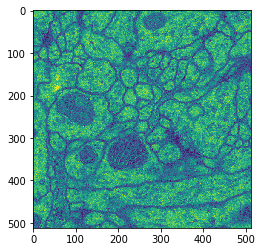

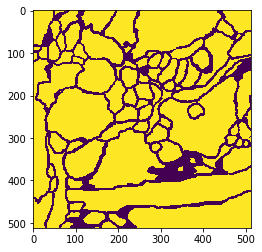

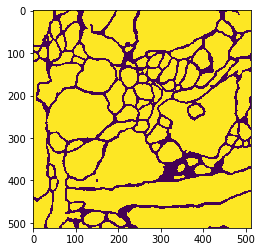

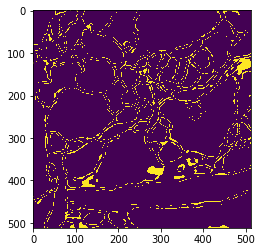

In [63]:
plot_val(0,TTA=False)

In [ ]:
#Apply plot_val to the first validation image with TTA set to True.

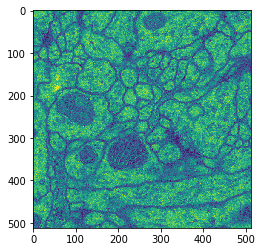

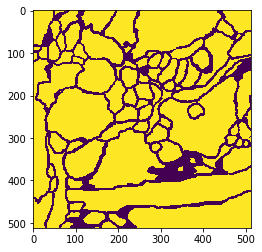

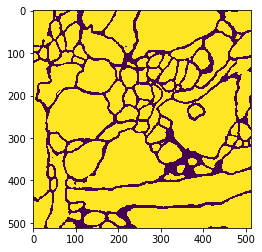

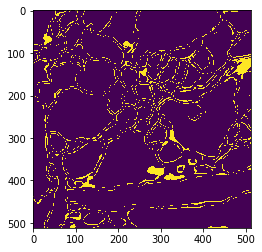

In [64]:
plot_val(0)

In [65]:
# We load the unlabeled test images. There are 30 of these as well.

In [66]:
tst_imgs = np.array(imageio.imread('./test/test-volume.tif'))
tst_imgs.shape

(30, 512, 512)

In [67]:
# We plot one of the test images.

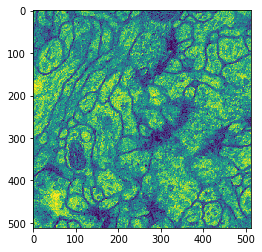

In [68]:
plt.imshow(tst_imgs[10])

In [69]:
# We preprocess the test images by centering and normalizing them.

In [70]:
tst_imgs = np.expand_dims(tst_imgs,axis=-1)
tst_imgs.shape

(30, 512, 512, 1)

In [71]:
tst_imgs = (tst_imgs - mean_all)/std_all

In [72]:
num_tst = len(tst_imgs)
num_tst

30

In [73]:
# The test_ds class produces the test images.

In [74]:
class test_ds():
    
    def __init__(self):
        return
    
    def __getitem__(self,indx):
        return self.get_img(indx)
    
    def get_img(self,indx):
        img = tst_imgs[indx]
        return img
    
    def __len__(self):
        return num_tst

In [75]:
tst_ds = test_ds()

In [76]:
# The plot_test function predicts the masks for the test set images. If TTA is set to True, then it performs 
# test-time augmentation, in which the image is flipped in the horiziontal and vertical directions, as well as in 
# both directions, and the results are averaged. It then plots the original image and the predicted mask.

In [77]:
def plot_test(indx,TTA=True):
    val_im = tst_ds[indx]
    val_im_plot = val_im * std_all + mean_all
    val_im_plot = np.squeeze(val_im_plot)
    plt.figure('val_im')
    plt.imshow(val_im_plot)
    if TTA is True:
        val_im_lr = np.fliplr(val_im)
        val_im_ud = np.flipud(val_im)
        val_im_lrud = np.fliplr(np.flipud(val_im))
        val_prob = unet.predict(np.array([val_im]))[0] + np.fliplr(unet.predict(np.array([val_im_lr]))[0]) \
        + np.flipud(unet.predict(np.array([val_im_ud]))[0]) + np.flipud(np.fliplr(unet.predict(np.array([val_im_lrud]))[0]))    
        val_prob = val_prob/4.0
    else: 
        val_prob = unet.predict(np.array([val_im]))[0] 
    val_prob = np.squeeze(val_prob)
    val_pred = val_prob > 0.5
    plt.figure('val_pred')
    plt.imshow(val_pred)
    

In [78]:
# Plot the first test image and the predicted mask with TTA set to False.

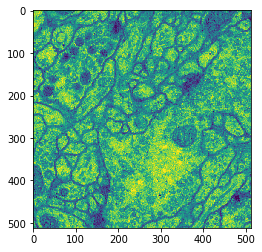

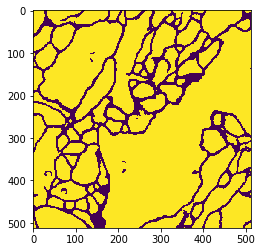

In [79]:
plot_test(0,TTA=False)

In [80]:
# Plot the first test image and the predicted mask with TTA set to True.

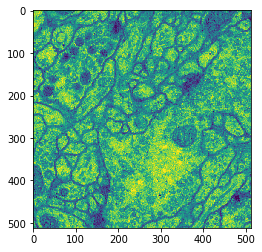

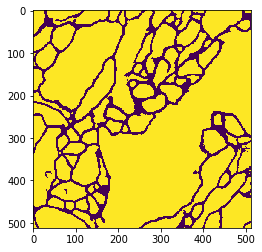

In [81]:
plot_test(0)